# Time
Objectives:
- Compare various cut-off points for the data

Method:
- Using the week of the data 52 weeks before the verification period as verification,
- Plot an estimate of the expected score
- By trying to predict what customers bought that week using the previous weeks as information

Reason:
- The other comparison might be biased because the evaluation week is on the edge of the season change


In [1]:
import numpy as np 
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import preprocessing
import time

In [2]:
transactions = pd.read_csv('./data/transactions_train.csv')

Replace customer ids with label encoding for space preservation purposes.

In [3]:
def encode_transactions_customers(transactions_df):
    customers = pd.read_csv('./data/customers.csv')
    customer_encoder = preprocessing.LabelEncoder()
    customer_encoder.fit(customers['customer_id'])
    transactions['customer_id'] = customer_encoder.transform(transactions['customer_id'])
    np.save('customer_ids.npy', customer_encoder.classes_) 
    return customer_encoder

In [4]:
customer_encoder = encode_transactions_customers(transactions)

In [5]:
transactions['purchased'] = 1

Transform string dates into weeks with the start of week 0 being the week for the final calculation (meaning everything in the data becomes a negative week)

In [6]:
def transform_string_dates_to_int(transactions_df):
    import datetime

    lookup = dict()
    def str_dat_to_weeks_int(datestring):
        return lookup.setdefault(datestring, (datetime.datetime.strptime(datestring, "%Y-%m-%d") - datetime.datetime(2020, 9, 23)).days//7)
    
    transactions_df["t_dat"] = transactions_df["t_dat"].map(str_dat_to_weeks_int)


In [7]:
transform_string_dates_to_int(transactions)

Drop all transactions which happened outside of the period used for this experiment (20 week period before the 3rd week of September)

In [8]:
transactions.drop(transactions[(transactions["t_dat"] < -72) | (transactions["t_dat"] > -52)].index, inplace=True)

Perform random negative sampling, most of this code is copied from the 2nd lecture

In [9]:
def generate_negative_samples_np_version(transactions_df, num_neg_pos):
    real_dates = transactions["t_dat"].unique()
    real_customers = transactions["customer_id"].unique()
    real_articles = transactions["article_id"].unique()
    real_channels = transactions["sales_channel_id"].unique()
    article_and_price = transactions[["article_id","price"]].drop_duplicates("article_id").set_index("article_id").squeeze()

    random.seed(42)
    num_neg_samples = int(num_neg_pos * 1.1)

    neg_dates = np.random.choice(real_dates, size=num_neg_samples)
    neg_articles = np.random.choice(real_articles, size=num_neg_samples)
    neg_customers = np.random.choice(real_customers, size=num_neg_samples)
    neg_channels = np.random.choice(real_channels, size=num_neg_samples)
    ordered = np.array([0] * num_neg_samples)

    neg_prices = article_and_price[neg_articles].values
    
    return np.column_stack((neg_dates, neg_customers, neg_articles, neg_prices, neg_channels, ordered))
    
def generate_negative_samples(transactions_df):
    num_neg_pos = transactions_df.shape[0]
    positive_pairs = list(map(tuple, transactions_df[['customer_id', 'article_id']].drop_duplicates().values))
    neg_transactions = pd.DataFrame(generate_negative_samples_np_version(transactions_df, num_neg_pos), columns=transactions_df.columns)
    duplicate_indexes = neg_transactions[["customer_id", "article_id"]].apply(tuple, 1).isin(positive_pairs)
    neg_transactions = neg_transactions[~duplicate_indexes]
    return neg_transactions.sample(num_neg_pos)

def negative_sampling(transactions_df):
    transactions_df = pd.concat([transactions_df, generate_negative_samples(transactions_df)])
    transactions_df.reset_index(drop=True, inplace=True)
    return transactions_df

In [10]:
transactions = negative_sampling(transactions)

In [11]:
transactions.to_feather('./data/negativesampled.feather')

This is intended as a checkpoint for if I need to reset the jupyter notebook kernel for whatever reason. 

In [38]:
articles = pd.read_csv('./data/articles.csv')

In [39]:
transactions = pd.read_feather("./data/negativesampled.feather")

In [40]:
customers = pd.read_csv('./data/customers.csv')

In [41]:
customer_encoder = preprocessing.LabelEncoder()
customer_encoder.classes_ = np.load("customer_ids.npy", allow_pickle=True)

Apply the label encoding to the customer table so it can be joined with transactions

In [42]:
customers['customer_id'] = customer_encoder.transform(customers['customer_id'])

In [43]:
zip_encoder = preprocessing.LabelEncoder()
customers["postal_code"] = zip_encoder.fit_transform(customers["postal_code"])

In [44]:
def correct_types_and_merge_transactions(transactions_df, customers_df, articles_df):
    customers_df["age"] = customers_df["age"].fillna(25)
    customers_df["age"] = customers_df["age"].astype(int)
    articles_df[['article_id', 'product_code', 'product_type_no','graphical_appearance_no','colour_group_code',
       'perceived_colour_value_id', 'perceived_colour_master_id', 'department_no',
       'index_group_no', 'section_no', 'garment_group_no']] = articles_df[['article_id', 'product_code',
       'product_type_no','graphical_appearance_no','colour_group_code',
       'perceived_colour_value_id', 'perceived_colour_master_id', 'department_no',
       'index_group_no', 'section_no', 'garment_group_no']].astype(int)
    transactions_df[['t_dat', 'customer_id', 'article_id', 'sales_channel_id', 'purchased']] = transactions_df[['t_dat', 'customer_id', 'article_id', 'sales_channel_id', 'purchased']].astype(int)

    transactions_df = transactions_df.merge(customers_df[["customer_id", "age", "postal_code"]], how="inner", on='customer_id')
    transactions_df = transactions_df.merge(articles_df[["article_id", "product_code", "product_type_no", "graphical_appearance_no", "colour_group_code", "department_no", "index_group_no", "section_no", "garment_group_no"]], how="inner", on='article_id')
    return transactions_df

In [45]:
transactions = correct_types_and_merge_transactions(transactions, customers, articles)

In [46]:
def split_time_train_test(transactions_df):
    train = transactions_df[transactions_df["t_dat"] < -52]
    test = transactions_df[transactions_df["t_dat"] == -52]
    X_train = train.drop(['purchased', "price", "sales_channel_id"], axis=1)
    X_test = test.drop(['purchased', "price", "sales_channel_id"], axis=1)
    y_train = train['purchased']
    y_test = test['purchased']
    return train, test, X_train, X_test, y_train, y_test

Calculate the popular items which I will be using as candidates for the submission.

In [47]:
def get_popular_items(transaction_df):
    popular_all_time = transaction_df[(transaction_df["purchased"] == 1)][["article_id", "purchased"]].groupby("article_id").count().sort_values(ascending=False, by="purchased").head(24).index.to_series().reset_index(drop=True)
    popular_last_week = transaction_df[(transaction_df["purchased"] == 1) & (transaction_df["t_dat"] >= -56)][["article_id", "purchased"]].groupby("article_id").count().sort_values(ascending=False, by="purchased").head(48).index.to_series().reset_index(drop=True)
    popular_last_week2 = popular_last_week[~popular_last_week.isin(popular_all_time)]
    popular_last_week2 = popular_last_week2.reset_index(drop=True).head(24)
    popular_candidates = pd.DataFrame(pd.concat([popular_all_time, popular_last_week2])).astype(int).reset_index(drop=True)
    return popular_candidates, popular_last_week

Generate dataframe with all active customers and the candidates

In [22]:
def generate_ranker_input_df(transactions_df, candidates, customers_df, articles_df):
    return pd.DataFrame(data={"t_dat": -1}, index=[0]).merge(transactions_df[transactions_df["t_dat"] == -52][["customer_id"]].drop_duplicates(subset="customer_id"), how="cross").merge(candidates, how="cross").merge(customers_df[["customer_id", "age", "postal_code"]], how="inner", on="customer_id").merge(articles_df[["article_id", "product_code", "product_type_no", "graphical_appearance_no", "colour_group_code", "department_no", "index_group_no", "section_no", "garment_group_no"]], how="inner", on="article_id")

Functions to perform predictions and calculate MAPS@12

In [23]:
# Copied from the radekosmulski notebook
def generate_ranking(df):
    return df.sort_values(by=["customer_id", "p1"], ascending=[True, False]).groupby("customer_id")["article_id"].apply(list).to_dict()

In [67]:
def predict_and_compare(df, classifier, filler_candidates, test, test_dictionary):
    predictions = classifier.predict_proba(df)
    df[["p0", "p1"]] = predictions
    ranking = generate_ranking(df)
    
    # Copied from the radekosmulski notebook
    preds = dict()
    for c_id in test["customer_id"].unique():
        pred = ranking.get(c_id, filler_candidates)
        preds[c_id] = pred[:12]
        
    score = 0
    for c_id in test_dictionary.keys():
        sum_pk = 0
        matches = 0
        for i, pred in enumerate(preds[c_id]):
            if pred in test_dictionary[c_id]:
                matches += 1
                sum_pk += matches / (i + 1)
        score += sum_pk / min(len(test_dictionary[c_id]), 12)
    
    df.drop(['p0', 'p1'], inplace=True, axis=1)
    return score / len(test_dictionary.keys())

In [58]:
def generate_dictionary_for_test(test):
    return test[test["purchased"] == 1].groupby("customer_id")["article_id"].apply(list).to_dict()

train, test, X_train, X_test, y_train, y_test = split_time_train_test(transactions)
test_dictionary = generate_dictionary_for_test(test)

Let's start with lightgbm binary classifier

In [63]:
# copying from https://github.com/microsoft/LightGBM/blob/master/examples/python-guide/simple_example.py
# combined with https://github.com/angelotc/LightGBM-binary-classification-example/blob/master/CCData.ipynb

import lightgbm as lgb

def train_gbm_ranker(X_train, y_train):

    gbm = lgb.LGBMClassifier(learning_rate = 0.1, metric = 'l1', 
                            n_estimators = 20, random_state=42)
    gbm.fit(X_train, y_train)
    
    return gbm

In [70]:
week_limit = 20
start_week = -52
scores = dict()
while week_limit > 0:
    temp_transactions = transactions.drop(transactions[transactions["t_dat"] < start_week - week_limit].index)
    train, test, X_train, X_test, y_train, y_test = split_time_train_test(temp_transactions)
    popular_candidates, popular_last_week = get_popular_items(train)
    ranker_input = generate_ranker_input_df(temp_transactions, popular_candidates, customers, articles)
    model = train_gbm_ranker(X_train, y_train)
    score = predict_and_compare(ranker_input, model, popular_last_week, test, test_dictionary)
    scores[week_limit] = score
    print(week_limit, score)
    week_limit -= 1

20 0.002855669793052882
19 0.002954431936730812
18 0.0030268977668264536
17 0.0027686461011033284
16 0.0027017031050119624
15 0.0026194640841275965
14 0.002281008725953581
13 0.002178744509099211
12 0.002706449247135919
11 0.0021063794921928544
10 0.002164634119395194
9 0.0024228623318216535
8 0.0028729433299294273
7 0.0029125358514429708
6 0.0027547253491510557
5 0.002615513228383332
4 0.0026035040075022557
3 0.0027565563374357155
2 0.0026059595808245756
1 0.0029243526087713734


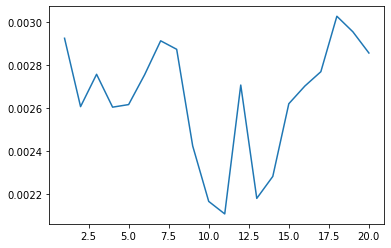

In [71]:
import matplotlib.pyplot as plt

plt.plot(range(1, 21), [scores[i] for i in range(1, 21)])

In [68]:
week_limit = 20
start_week = -52
scores2 = dict()
popular_candidates, popular_last_week = get_popular_items(train)
while week_limit > 0:
    temp_transactions = transactions.drop(transactions[transactions["t_dat"] < start_week - week_limit].index)
    train, test, X_train, X_test, y_train, y_test = split_time_train_test(temp_transactions)
    ranker_input = generate_ranker_input_df(temp_transactions, popular_candidates, customers, articles)
    model = train_gbm_ranker(X_train, y_train)
    score = predict_and_compare(ranker_input, model, popular_last_week, test, test_dictionary)
    scores2[week_limit] = score
    print(week_limit, score)
    week_limit -= 1

20 0.002855669793052882
19 0.002954431936730812
18 0.003077592914921415
17 0.002872986905020681
16 0.0030591357227081717
15 0.002808382827997076
14 0.00263293783733532
13 0.002793033062145686
12 0.003440035221498224
11 0.0027766945924196955
10 0.0030874798765460837
9 0.0029504205088253153
8 0.0029538231823170616
7 0.003163598972973461
6 0.0032037670445314624
5 0.0033962242583625373
4 0.0033266829527865225
3 0.003037656584703245
2 0.002775591755585958
1 0.0028763134374562597


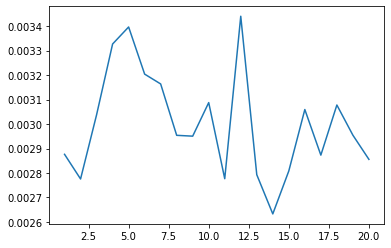

In [69]:


plt.plot(range(1, 21), [scores2[i] for i in range(1, 21)])